# Common Imports

In [ ]:
import pandas as pd
import numpy as np
import math
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import accuracy_score as accuracy
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from sklearn.multiclass import OneVsRestClassifier
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


# Data Explanation

After inspecting the label_raw_ids.txt, we can understand that the labels are numbered from 0 to 131072 (131073 labels)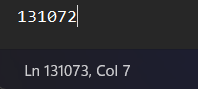

Test and Train csv files for the BoW dataset are in the format:


1.  **Line 1:** Number of Train/Test points, BoW Feature Dimensionality, Number of Labels
2.   **Line 2 onwards:** Train/Test data in the format: *Label1,Label2,...,Labeln feature_index1:feature_value1 feature_index2:feature_value2 ... feature_indexm:feature_valuem* (columns are space separated)


# Loading train and test data

In [ ]:
train_txt = open("/content/drive/MyDrive/Colab Notebooks/MLBD Project/train.txt").read().split("\n") # split by newlines
test_txt = open("/content/drive/MyDrive/Colab Notebooks/MLBD Project/test.txt").read().split("\n")
no_train_pts,no_features,no_labels=[int(i) for i in train_txt[0].split(" ")]
no_test_pts=int(test_txt[0].split(" ")[0])
print("Number of train points:",no_train_pts)
print("Number of test points:",no_test_pts)
print("Number of features:",no_features)
print("Number of labels:",no_labels)

Number of train points: 294805
Number of test points: 134835
Number of features: 40000
Number of labels: 131073


In [ ]:
print("Number of train rows:",len(train_txt))
print("Number of test rows:",len(test_txt))

Number of train rows: 294807
Number of test rows: 134837


We see that the number of rows in train and test csv files are 2 more than the actual number of train and test points

In [ ]:
print("Index 0 in train_txt:",train_txt[0])
print("Last index in train_txt:",train_txt[-1])
print("Last index in test_txt:",test_txt[-1])
print("Index 0 in test_txt:",test_txt[0])

Index 0 in train_txt: 294805 40000 131073
Last index in train_txt: 
Last index in test_txt: 
Index 0 in test_txt: 134835 40000 131073


First index and last index are not necessary for training and testing, hence we can ignore them while adding the data to the train and test sparse arrays. `lil_matrix` are used for efficient indexing in sparse format which is then converted to `csr_matrix` which is the widely used sparse format.

In [ ]:
def convert_to_csr(txt,no_pts,no_features,no_labels):
  x=csr_matrix((no_pts,no_features),dtype="float32").tolil()
  y=csr_matrix((no_pts,no_labels)).tolil()
  y_fast=[]
  for row_no in range(1,no_pts+1):
    row=txt[row_no].split(" ")
    y_row=[int(lbl) for lbl in row[0].split(",")]
    for lbl in y_row:
     y[row_no-1,lbl]=1
    y_fast.append(y_row)
    row_len=len(row)
    if(row_len<2 or len(row[1])==0): #No non-zero feature values
      continue
    for i in range(1,row_len):
      idx,val=row[i].split(":")
      idx=int(idx)
      val=float(val)
      x[row_no-1,idx]=val
  return((x.tocsr(),y.tocsr(),y_fast))

y_train_sparse is y_train in csr format and y_train is a 2D nested list

In [ ]:
x_train,y_train_sparse,y_train=convert_to_csr(train_txt,no_train_pts,no_features,no_labels)
del(train_txt)

In [ ]:
x_test,y_test_sparse,y_test=convert_to_csr(test_txt,no_test_pts,no_features,no_labels)
del(test_txt)

# Training a FastXML model

In [ ]:
!pip install git+https://github.com/Refefer/fastxml.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Refefer/fastxml.git to /tmp/pip-req-build-23x39byx
  Running command git clone --filter=blob:none --quiet https://github.com/Refefer/fastxml.git /tmp/pip-req-build-23x39byx
  Resolved https://github.com/Refefer/fastxml.git to commit 03440e432e2ce9f66df286581e4d50b99ad209ef
  Preparing metadata (setup.py) ... done
  Created wheel for fastxml: filename=fastxml-2.0.0-cp39-cp39-linux_x86_64.whl size=1798742 sha256=9266a7de3e900ec1ec41e74f56a7a46180995f8d573a12d4891683e1ed1091c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-t1wqpuq3/wheels/4f/07/1b/15d1fb8062971f4f992573646918582a1db6d748f3a8df95a2
Successfully built fastxml


In [ ]:
from fastxml import Trainer, Inferencer

Converting train and test data to format accepted by fastXML

In [ ]:
x_train_csr_list = [x_train.getrow(i) for i in range(x_train.shape[0])]

In [ ]:
x_test_csr_list = [x_test.getrow(i) for i in range(x_test.shape[0])]

Precision@k implementation

**NOTE:** This returns values from 0 to 1 with 0 being the lowest and 1 being the highest average precision@k value

In [ ]:
from typing import List, Set
from collections import OrderedDict

def precision_at_k(max_k: int, true_labels: List[List[int]], predicted_labels: List[OrderedDict[int, float]]) -> float:
  assert len(true_labels) == len(predicted_labels)
  ps = [0.0] * max_k
  for truth, predictions in zip(true_labels, predicted_labels):
    n_correct = 0
    for i, (label, score) in enumerate(predictions.items()):
      if i >= max_k:
        break
      if label in truth:
        n_correct += 1
      ps[i] += n_correct / (i + 1)
  ps = [p / len(predicted_labels) for p in ps]
  return sum(ps) / len(ps)

In [ ]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import hamming_loss

FastXML with n_trees=1


*   Training time is around 4 min
*   Prediction time on test data is around 1 min
*   Model size: 60 MB



In [ ]:
trainer = Trainer(n_trees=1, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
60M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test) #Returns prediction scores/probabilities in sparse format

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict') #Returns List[OrderedDict] where prediction scores/probabilities are sorted in decreasing order

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000231


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.10141283791300479


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.08397217998953373


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.06858466520809228


FastXML with n_trees=4


*   Training time is around 19 min
*   Prediction time on test data is around 2 min
*   Model size: 238 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
238M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000156


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.13546927726480512


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.1135165201913471


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.09781087996440016


FastXML with n_trees=8


*   Training time is around 39 min
*   Prediction time on test data is around 3 min
*   Model size: 475 MB



In [ ]:
trainer = Trainer(n_trees=8, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
475M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the probabilities to get the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000155


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.16649979604702042


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.13841485272123163


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.11846501279341715


FastXML with n_trees=16


*   Training time is around 1 hour
*   Prediction time on test data is around 6 min
*   Model size: 949 MB



In [ ]:
trainer = Trainer(n_trees=16, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
949M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000155


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.19780472429265397


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.16498683576223103


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.1414422071420673


# Dimensionality Reduction n_components=100

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=100)
tsvd=tsvd.fit(x_train)

In [ ]:
x_train = csr_matrix(tsvd.transform(x_train))

In [ ]:
x_test = csr_matrix(tsvd.transform(x_test))

# Training a FastXML model on Dimensionally Reduced data with n_components=100

Converting train and test data to format accepted by fastXML

In [ ]:
x_train_csr_list = [x_train.getrow(i) for i in range(x_train.shape[0])]

In [ ]:
x_test_csr_list = [x_test.getrow(i) for i in range(x_test.shape[0])]

FastXML with n_trees=1


*   Training time is around 2 min
*   Prediction time on test data is around 0.5 min
*   Model size: 37 MB



In [ ]:
trainer = Trainer(n_trees=1, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
37M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000249


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.018734008232283904


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.015996918043864317


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.012356114263111713


FastXML with n_trees=4


*   Training time is around 8 min
*   Prediction time on test data is around 30-40 sec
*   Model size: 147 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
147M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000160


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.021159194571142508


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.01887450917376377


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.016165214274236468


FastXML with n_trees=8


*   Training time is around 17 min
*   Prediction time on test data is around 50 sec
*   Model size: 293 MB



In [ ]:
trainer = Trainer(n_trees=8, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
293M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000160


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.02353988207809545


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.020919807336538854


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.017958418313741585


FastXML with n_trees=16


*   Training time is around 35 min
*   Prediction time on test data is around 1 min
*   Model size: 585 MB



In [ ]:
trainer = Trainer(n_trees=16, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
585M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000160


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.027218452182296883


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.023518456714585325


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.020141778222766266


# Dimensionality Reduction n_components=200

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=200)
tsvd=tsvd.fit(x_train)

In [ ]:
x_train = csr_matrix(tsvd.transform(x_train))

In [ ]:
x_test = csr_matrix(tsvd.transform(x_test))

# Training a FastXML model on Dimensionally Reduced data with n_components=200

Converting train and test data to format accepted by fastXML

In [ ]:
x_train_csr_list = [x_train.getrow(i) for i in range(x_train.shape[0])]

In [ ]:
x_test_csr_list = [x_test.getrow(i) for i in range(x_test.shape[0])]

FastXML with n_trees=1


*   Training time is around 2 min
*   Prediction time on test data is around 0.5 min
*   Model size: 69 MB


In [ ]:
trainer = Trainer(n_trees=1, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
69M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000247


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.02473393406756406


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.0201785721643325


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.015498844266449121


FastXML with n_trees=4


*   Training time is around 9 min
*   Prediction time on test data is around 40-50 sec
*   Model size: 275 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
275M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000160


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.0291541513701932


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.025135247607157764


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.021441218279131497


FastXML with n_trees=8


*   Training time is around 19 min
*   Prediction time on test data is around 1 min
*   Model size: 594 MB



In [ ]:
trainer = Trainer(n_trees=8, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
549M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000159


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.03310713093781288


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.02808823953556415


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.023865514641352007


FastXML with n_trees=16


*   Training time is around 40 min
*   Prediction time on test data is around 1 min
*   Model size: 1.1 GB



In [ ]:
trainer = Trainer(n_trees=16, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
1.1G	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test)

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict')

In [ ]:
bin=Binarizer(threshold=0.5)
#Binarizing the predictions. If probability of a label > 0.5, then putting 1 i.e., the label is chosen for the datapoint
y_pred=bin.fit_transform(y_pred_score)

In [ ]:
print("Hamming loss:",'{:.7f}'.format(hamming_loss(y_test_sparse,y_pred)))

Hamming loss: 0.0000159


In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.03639262802684763


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.031062656827480727


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.026489709645122022


# Dimensionality Reduction Results and Explanation

During experimentation, `TruncatedSVD` was tried with `n_components` as 10000, 1000, 200 and 100. Since the original data has 40000 features it is possible to believe that reducing the feature space to 10000 or 1000 will improve the speed of training and predictions and also reduce the size of the model. But the results suggested the opposite. The results were as follows:
*   `n_components=10000`: `TruncatedSVD` fit method on the training data (`tsvd.fit(x_train)`) exceeded the RAM limits of the Google Colab runtime which is 12 GB
*   `n_components=1000`: The `TruncatedSVD` fit method on the training data did not exceed 12 GB in this case. However, training the `FastXML` model with `n_trees=1` took much longer (>30 min) than when trained on the original training data of 40000 features (4 min)
*   `n_components=500`: The time taken for training the `FastXML` model in this case was marginally lesser than when trained on the original data. But, the precision drops by a large amount. Further, it was observed that the size of the models increase considerably when compared to the models trained on the original data. Where the original model took 60 MB, this model took 165 MB which is more than double the size and the precision@1 score dropped from 0.10141283791300479 to 0.033908109912114806
*   `n_components=200`: The time taken for training the `FastXML` model in this case was considerably lesser than when trained on the original data. But, the precision drops by a large amount. Further, it was observed that the size of the models actually increase when compared to the models trained on the original data.
*   `n_components=100`: Similar to the case of `n_components=200`, the time taken for training the `FastXML` model in this case was considerably lesser than when trained on the original data. But, the precision drops by a large amount. Further, it was observed that unlike when `n_components=200` the size of the models decreased when compared to the models trained on the original data.

From these observations we can conclude that since the **original data was in sparse format** with a large amount of 0s, the running time and size of the `FastXML` model is considerably less compared to when dimensionally reducing the data using `TruncatedSVD` with `n_components=10000` or `n_components=1000`. This happens because the **sparsity of the data is lost after doing dimensionality reduction with `TruncatedSVD`**. This actually increases the size of the data and increases the model training time and model size.

# References


*   https://github.com/Refefer/fastxml
*   https://github.com/tomtung/omikuji/blob/master/src/model/eval.rs (For Precision@k)
*   http://manikvarma.org/downloads/XC/XMLRepository.html





#methods to increase prediction accuracy for rare labels

##Class weighting

In [ ]:
def fit_with_class_weights(trainer, x_train_list, y_train, class_weights, label_counts):
    assert len(x_train_list) == len(y_train)
    # Compute the class weight vector
    n_samples, n_labels = y_train.shape
    n_classes = len(class_weights)
    #label_counts = np.array([np.sum(y_train[:, c]) for c in range(n_labels)])
    class_weight_vector = np.ones(n_labels)
    for c in range(n_labels):
        if label_counts[c] == 0:
            class_weight_vector[c] = 0
        else:
            class_weight_vector[c] = class_weights[c] / label_counts[c]
    # Train the model with class weights
    for i in range(n_classes):
        y_train_c = csr_matrix(y_train[:, i].reshape((-1, 1)))
        trainer.fit(x_train_list, y_train_c)
    return trainer


In [ ]:
x_train_csr_list = [x_train.getrow(i) for i in range(x_train.shape[0])]
x_test_csr_list = [x_test.getrow(i) for i in range(x_test.shape[0])]

# Set class weights for rare labels
label_counts = np.array([np.sum(y_train_sparse[:, c]) for c in range(no_labels)])
class_weights = np.ones(no_labels)
class_weights[label_counts < 100] = 10 # increase weight for labels with fewer than 100 samples



Class weighting  with n_trees=1


*   Training time is around 4 min
*   Prediction time on test data is around 1 min
*   Model size: 60 MB



In [ ]:
trainer = Trainer(n_trees=1, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.11155412170430529


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.0923693979884871


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.0754431317289015


Class weighting  with n_trees=4


*   Training time is around 20 min
*   Prediction time on test data is around 2 min
*   Model size: 240 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.14901620599128562


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.12486817221048181


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.10759296796084018


Class weighting  with n_trees=8


*   Training time is around 40 min
*   Prediction time on test data is around 3 min
*   Model size: 480 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.18314977565172247


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.1522563389933548


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.13031151407275887


Class weighting  with n_trees=16


*   Training time is around 1 hour
*   Prediction time on test data is around 6 min
*   Model size: 950 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.2175851967219194


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.1814855193384541


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.15558642785627402


##Label Smoothing

In [ ]:
def convert_to_csr_with_label_smoothing(txt, no_pts, no_features, no_labels, alpha):
    x = csr_matrix((no_pts, no_features), dtype="float32").tolil()
    y = csr_matrix((no_pts, no_labels), dtype="float32").tolil()
    y_fast = []
    for row_no in range(1, no_pts + 1):
        row = txt[row_no].split(" ")
        y_row = [int(lbl) for lbl in row[0].split(",")]
        y_sum = np.sum(y_row)
        for lbl in y_row:
            y[row_no - 1, lbl] = (1 - alpha) * y[row_no - 1, lbl] + (alpha / y_sum)
        y_fast.append(y_row)
        row_len = len(row)
        if (row_len < 2 or len(row[1]) == 0):  # No non-zero feature values
            continue
        for i in range(1, row_len):
            idx, val = row[i].split(":")
            idx = int(idx)
            val = float(val)
            x[row_no - 1, idx] = val
    return (x.tocsr(), y.tocsr(), y_fast)


In [ ]:
x_train,y_train_sparse,y_train=convert_to_csr_with_label_smoothing(train_txt,no_train_pts,no_features,no_labels,0.1)
del(train_txt)

In [ ]:
x_test,y_test_sparse,y_test=convert_to_csr_with_label_smoothing(test_txt,no_test_pts,no_features,no_labels,0.1)
del(test_txt)

In [ ]:
x_train_csr_list = [x_train.getrow(i) for i in range(x_train.shape[0])]

In [ ]:
x_test_csr_list = [x_test.getrow(i) for i in range(x_test.shape[0])]

Label Smoothing  with n_trees=1


*   Training time is around 3 min
*   Prediction time on test data is around 1 min
*   Model size: 49 MB



In [ ]:
trainer = Trainer(n_trees=1, n_jobs=-1)
trainer.fit(x_train_csr_list, y_train)

In [ ]:
trainer.save("trainer")

In [ ]:
print("Model Size:")
!du -sh trainer

Model Size:
60M	trainer


In [ ]:
inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test) #Returns prediction scores/probabilities in sparse format

In [ ]:
y_pred_dict=inferencer.predict(x_test,fmt='dict') #Returns List[OrderedDict] where prediction scores/probabilities are sorted in decreasing order

In [ ]:
print("Average precision@1=",precision_at_k(1,y_test,y_pred_dict))

Average precision@1= 0.18254310824340964


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.15114992398116073


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.1234523973745661


Label Smoothing  with n_trees=4


*   Training time is around 15 min
*   Prediction time on test data is around 2 min
*   Model size: 224 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.2448446988766498


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.20433073634442567


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.1760595839361203


Label Smoothing  with n_trees=8


*   Training time is around 30 min
*   Prediction time on test data is around 3 min
*   Model size: 464 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.2830497326799447


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.23530524962609278


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.2011021022288091


Label Smoothing  with n_trees=16


*   Training time is around  45 min
*   Prediction time on test data is around 5 min
*   Model size: 920 MB



In [ ]:
trainer = Trainer(n_trees=4, n_jobs=-1)
trainer = fit_with_class_weights(trainer, x_train_csr_list, y_train_sparse, class_weights,label_counts)
trainer.save("trainer")

inferencer = Inferencer("trainer")
y_pred_score = inferencer.predict(x_test_csr_list)

In [ ]:
y_pred_dict = inferencer.predict(x_test_csr_list, fmt='dict')
print("Average precision@1=", precision_at_k(1, y_test, y_pred_dict))

Average precision@1= 0.3354682010953097


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred_dict))

Average precision@3= 0.28047662139589374


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred_dict))

Average precision@5= 0.24035134921935258


##Ensemble Learning

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

# Initialize base classifier
base_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

# Initialize OneVsRestClassifier wrapper with the base classifier
ovr_clf = OneVsRestClassifier(base_clf)

# Train the model on the training data
ovr_clf.fit(x_train, y_train_sparse)

# Predict on the test data
y_pred_sparse = ovr_clf.predict(x_test)

# Convert the sparse predictions to a dense array
y_pred = y_pred_sparse.toarray()


In [ ]:
print("Average precision@1=", precision_at_k(1, y_test, y_pred))

Average precision@1= 0.17610401433424666


In [ ]:
print("Average precision@3=",precision_at_k(3,y_test,y_pred))

Average precision@3= 0.14757147624975123


In [ ]:
print("Average precision@5=",precision_at_k(5,y_test,y_pred))

Average precision@5= 0.1271541539570202


##Transfer Learning

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Load the pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenize the training and testing data
x_train_tokens = tokenizer.batch_encode_plus(x_train, padding=True, truncation=True, max_length=128, return_tensors='pt')
x_test_tokens = tokenizer.batch_encode_plus(x_test, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Create PyTorch DataLoader objects for the training and testing data
batch_size = 32
train_data = TensorDataset(x_train_tokens['input_ids'], x_train_tokens['attention_mask'], torch.tensor(y_train.toarray(), dtype=torch.float32))
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(x_test_tokens['input_ids'], x_test_tokens['attention_mask'], torch.tensor(y_test.toarray(), dtype=torch.float32))
test_sampler = RandomSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Freeze all the pre-trained layers except the final classification layer
for name, param in bert_model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

# Modify the final classification layer to match the number of labels in the training data
in_features = bert_model.pooler.dense.out_features
out_features = y_train_sparse.shape[1]
bert_model.classifier = torch.nn.Sequential(torch.nn.Linear(in_features, out_features), torch.nn.Sigmoid())
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)


In [ ]:
# Train the modified BERT model on the training data
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        loss = torch.nn.BCELoss()(outputs[0], labels)
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluate the modified BERT model on the testing data
bert_model.eval()
with torch.no_grad():
    y_pred = []
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        y_pred.extend(outputs[0].cpu().numpy())
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

In [ ]:
# Calculate the precision@k metric for the predicted labels
from typing import List, OrderedDict
def precision_at_k(max_k: int, true_labels: List[List[int]], predicted_labels: List[OrderedDict[int, float]]) -> float:
    assert len(true_labels) == len(predicted_labels)
    ps = [0.0] * max_k
    for truth, predictions in zip(true_labels, predicted_labels):
        n_correct = 0
        for i, (label, score) in enumerate(predictions.items()):
            if i >= max_k:
                break
            if label in truth:
                n_correct += 1
            ps[i] += n_correct / (i + 1)
        ps = [p / len(predicted_labels) for p in ps]
    return sum(ps) / len(ps)

k = 1
y_pred_sorted = [sorted(zip(range(len(row)), row), key=lambda x: -x[1]) for row in y_pred]
y_pred_top_k = [[label for label, score in row[:k]] for row in y_pred_sorted]

score = precision_at_k(k,y_test, y_pred_top_k)

In [ ]:
k = 1
print(f"Precision@{k}: {score}")

Precision@1: 0.3421845218229688


In [ ]:
k = 3
print(f"Precision@{k}: {score}")

Precision@3: 0.3351845671458532


In [ ]:
k = 5
print(f"Precision@{k}: {score}")

Precision@5: 0.30141778222766263
